In [1]:
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import GridSearchCV
import pandas as pd
import sklearn 
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectPercentile, SelectKBest, f_regression, chi2, VarianceThreshold
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import ExtraTreesRegressor
from pymatgen.analysis import magnetism
import tqdm
from mat2vec.processing import MaterialsTextProcessor
import tqdm
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from pymatgen import Composition

C:\Users\giovanni\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
'''
Class to be imported in pipeline (below) for dropping the most correlated columns, preventing data leakage.
'''

class MyDecorrelator(BaseEstimator, TransformerMixin): 
    
    def __init__(self, threshold):
        self.threshold = threshold
        self.correlated_columns = None

    def fit(self, X, y=None):
        correlated_features = set()  
        X = pd.DataFrame(X)
        corr_matrix = X.corr()
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > self.threshold: # we are interested in absolute coeff value
                    colname = corr_matrix.columns[i]  # getting the name of column
                    correlated_features.add(colname)
        #print(np.shape(pd.DataFrame(X).drop(labels=correlated_features, axis=1)))
        #print(pd.DataFrame(X).drop(labels=correlated_features, axis=1))
        self.correlated_features = correlated_features
        return self

    def transform(self, X, y=None, **kwargs):
        return (pd.DataFrame(X)).drop(labels=self.correlated_features, axis=1)

In [4]:
Elements = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 
    'S','Cl','Ar','K','Ca','Sc','Ti','V','Cr','Mn','Fe','Co','Ni','Cu','Zn',
    'Ga','Ge','As','Se','Br','Kr','Rb','Sr','Y','Zr','Nb','Mo','Tc','Ru',
    'Rh','Pd','Ag','Cd','In','Sn','Sb','Te','I','Xe','Cs','Ba','La','Ce',
    'Pr','Nd','Pm','Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb','Lu','Hf',
    'Ta','W','Re','Os','Ir','Pt','Au','Hg','Tl','Pb','Bi','Po','At','Rn',
    'Fr','Ra','Ac','Th','Pa','U','Np','Pu','Am','Cm','Bk','Cf','Es','Fm',
    'Md','No','Lr','Rf','Db','Sg','Bh','Hs','Mt','Ds','Rg','Cn','Uut',
    'Fl','Uup','Lv','Uus','Uuo']

SuperCon = pd.read_excel(r'C:\\Users\\giovanni\\Desktop\\new_supercon.xlsx')
SuperCon = SuperCon[['element', 'tc', 'year.1']]
SuperCon.rename(columns = {'element':'Components'}, inplace = True)
SuperCon.rename(columns = {'tc':'Tc'}, inplace = True)
SuperCon.rename(columns = {'year.1':'year'}, inplace = True)
        
for i in range(len(SuperCon)):
    if '-' in SuperCon['Components'].iloc[i]:
        SuperCon['Tc'][i] = np.NaN

for i in range(len(SuperCon)):
    if ',' in SuperCon['Components'].iloc[i]:
        SuperCon['Tc'][i] = np.NaN
        
for i in range(len(SuperCon)):
    if '+' in SuperCon['Components'].iloc[i]:
        SuperCon['Tc'][i] = np.NaN
import re
S2 = set(Elements)

for i in range(len(SuperCon)):
    list_1 = re.findall('[A-Z][a-z]|[A-Z]', SuperCon['Components'].iloc[i])
    S1 = set(list_1)
    
    if len(S1) > len(S1.intersection(S2)):
        if not SuperCon['Tc'].isna().iloc[i]:
            print(SuperCon['Components'].iloc[i])

            SuperCon['Tc'].iloc[i] = np.NaN

Yb16Ba1Cu2Oz
Yb1.8Ba0.2Cu1Oz
Yb6Ba1Cu1Oz
Yb1.62La0.18Ba0.18Sr0.02Cu1Oz
Y0.4Ba0.6Cu1OX
Y0.4Ba0.6Cu1OX
Er0.5Ba0.5Cu1OX
Tm0.35Ba0.65Cu1OX
Tm0.3Ba0.7Cu1OX
Tm0.25Ba0.75Cu1OX
Tm0.2Ba0.8Cu1OX
Y1Ba2Cu3OX
Nd0.4Ba0.6Cu1OX
Nd2Ba3Cu5OX
Sm1Ba2Cu3OX
Gd2Ba3Cu5OX
Y1Ba2Cu3OX
Y1Ba2Cu3OX
Y0.8Ba1.2Cu1OX
Y0.6Ba0.9Cu1OX
Yb1.6La0.2Ba0.2Cu1Oz
Y0.4Ba0.6Cu1OX
Er1Ba2Cu3OX
Ho1Ba2Cu3OX
Gd1Ba2Cu3OX
Eu1.5Ba1.5Cu3Oz
Gd1.5Ba1.5Cu3Oz
Y1.5Ba1.5Cu3Oz
Yb1.5Ba1.5Cu3Oz
Y1Ba2Cu3F0.066Oz
Y1Ba2Cu3F0.066Oz
Y1Ba2Cu3F0.165Oz
Y1Ba2Cu3F0.016Oz
Y1Ba2Cu3F0.033Oz
Y1Ba2Cu3F0.05Oz
Y1Ba2Cu3Oz
Y1Ba2Cu3Oz
Gd1Ba2Cu3Oz
Er1Ba2Cu3OX
Dy1Ba2Cu3OX
Ho1Ba2Cu3OX
Y1Ba2Cu3OX
La1.85Sr0.15Cu0.97Ni0.03OX
Tl2Ca2Ba1Cu3OX
Tl2Ca2Ba2Cu3OX
Y1Ba2Cu3Oz
Y1Ba2Cu2.85Ti0.15Oz
Y1Ba2Cu2.7Ti0.3Oz
Y1Ba2Cu2.55Ti0.45Oz
Y1Ba2Cu2.4Ti0.6Oz
Y1Ba2Cu2.25Ti0.75Oz
Y1Ba2Cu2.1Ti0.9Oz
Bi1Sr1Ca1Cu2Oz
Bi2Sr1.8Ca1.2Cu2Oz
Bi2Sr3Ca4Cu8Oz
Bi1Sr1Ca1Cu2Oz
Gd1Ba2Cu3OX
Gd1Ba1.8Sr0.2Cu3OX
Gd1Ba1.6Sr0.4Cu3OX
Gd1Ba1.4Sr0.6Cu3Oz
Gd1Ba1.2Sr0.8Cu3Oz
Gd1Ba1Sr1Cu3Oz
Bi1Ca1Sr1Cu2Oz
Bi1Ca1Sr1Cu2Oz
Eu1B

Tl0.3Hg0.7Sr2Ba2Cu2Co3Oz
Tl0.2Hg0.8Sr2Ba2Cu2Co3Oz
Tl0.1Hg0.9Sr2Ba2Cu2Co3Oz
TlHg1Sr2Ba2Cu2Co3Oz
Tl1HgSr2Ba2Cu2Co3Oz
TlHg1Sr2Ba2Cu2Co3Oz
Ga0.3Hg0.7Sr2Y0.3Ca0.7Cu2OZ
Ga0.5Hg0.5Sr2Y0.3Ca0.7Cu2OZ
Ga0.7Hg0.3Sr2Y0.3Ca0.7Cu2OZ
Ga0.3Hg0.7Sr2Y0.5Ca0.5Cu2OZ
Ga0.5Hg0.5Sr2Y0.5Ca0.5Cu2OZ
Ga0.7Hg0.3Sr2Y0.5Ca0.5Cu2OZ
Hg1Tl1Ba4Ca2Cu4OZ
Hg1Tl1Ba4Ca4Cu6OZ
Hg1Tl2Ba4Ca2Cu4OZ
Hg1Tl2Ba4Ca4Cu6OZ
Hg1Tl2Ba4Ca4Cu6OZ
Hg1Tl1Sr4Ca2Cu4OZ
Hg1Tl2Sr4Ca2Cu4OZ
Hg1Tl2Sr4Cu6OZ
Cd1Ba2Ca0.7Y0.3Cu2Oz
Hg0.7Pb0.3Sr2Ca0.7Y0.3Cu2Oz
Hg0.5Pb0.5Sr2Ca0.5Y0.5Cu2Oz
Hg0.5Pb0.5Sr2Ca0.7Y0.3Cu2Oz
Bi0.3Pb0.5Cu0.2Sr2Dy0.75Ca0.25Cu2Oz
Bi0.3Pb0.5Cu0.2Sr2Dy0.5Ca0.5Oz
Hg0.7Cr0.3Sr2Cu1OZ
Hg0.7Cr0.3Sr2Cu1Oz
Bi2Sr2Ca1Cu2OZ
Zn0.005Pc0.005Bi2Sr2Ca1Cu2Oz
Zn0.01Pc0.01Bi2Sr2Ca1Cu2Oz
Zn0.02Pc0.02Bi2Sr2Ca1Cu2Oz
Bi2Sr2Ca2Cu3Oz
Zn0.005Pc0.005Bi2Ca2Cu3Oz
Zn0.01Pc0.01Bi2Sr2Ca2Cu3Oz
Hg1Sr2Ca1Cu1.8Re0.2Oz
Hg0.75Re0.25Sr2Ca2Cu3Oz
Hg0.75Re0.25Sr2Ca2Cu3Oz
Hg0.5Pb0.5Sr2Gd1.5Ce0.5Cu2Oz
Nb1Sr2Sm1.2Ce0.8Cu2OZ
Ru0.32Nb0.68Sr2Sm1.2Ce0.8Cu2Oz
Ru0.5Nb0.5Sr2Sm1.2Ce0.8Cu2Oz

Bi2Sr2Ca0.9Tb0.1Cu2OZ
Bi2Sr2Ca0.8Tb0.2Cu2Oz
Bi2Sr2Ca0.6Tb0.4Cu2Oz
Y1Ba2Cu3OZ
Y1Ba1.95La0.05Cu3OZ
Y1Ba1.9La0.1Cu3OZ
Y1Ba1.85La0.15Cu3OZ
Y1Ba1.8La0.2Cu3OZ
Y1Ba1.75La0.25Cu3OZ
Y1Ba1.7La0.3Cu3OZ
Y1Ba1.6La0.4Cu3OZ
Y1Ba1.5La0.5Cu3OZ
Y1Ba2Cu3OZ
Y1Ba1.95Pr0.05Cu3OZ
Y1Ba1.9Pr0.1Cu3OZ
Y1Ba1.85Pr0.15Cu3OZ
Y1Ba1.8Pr0.2Cu3OZ
Y1Ba1.75Pr0.25Cu3OZ
Y1Ba1.8Nd0.2Cu3OZ
Y0.95Ca0.05Ba1.8Nd0.2Cu3OZ
Y0.9Ca0.1Ba1.8Nd0.2Cu3OZ
Y0.85Ca0.15Ba1.8Nd0.2Cu3OZ
Y0.8Ca0.2Ba1.8Nd0.2Cu3OZ
Y0.75Ca0.25Ba1.8Nd0.2Cu3OZ
Y0.7Ca0.3Ba1.8Nd0.2Cu3OZ
Y0.6Ca0.4Ba1.8Nd0.2Cu3OZ
Y0.5Ca0.5Ba1.8Nd0.2Cu3OZ
Y0.8Ca0.2Ba2Cu3OZ
Y0.8Ca0.2Ba1.95Nd0.05Cu3OZ
Y0.8Ca0.2Ba1.9Nd0.1Cu3OZ
Y0.8Ca0.2Ba1.85Nd0.15Cu3OZ
Y0.8Ca0.2Ba0.8Nd0.2Cu3OZ
Y0.8Ca0.2Ba1.75Nd0.25Cu3OZ
Y0.8Ca0.2Ba1.7Nd0.3Cu3OZ
Y0.8Ca0.2Ba1.6Nd0.4Cu3OZ
Y0.8Ca0.2Ba1.5Nd0.5Cu3OZ
Tl0.5Pb0.5Sr1.6Ba0.4Ca2Cu3OZ
Tl0.5Pb0.5Sr1.6Ba0.4Ca2Cu3F0.1OZ
Tl0.5Pb0.5Sr1.6Ba0.4Ca2Cu3F2.2OZ
Tl0.5Pb0.5Sr1.6Ba0.4Ca2Cu3F3OZ
Pb0.5V0.5Sr2Ca0.7Er0.3Cu2OZ
Pb0.5V0.5Sr2Ca0.65Er0.35Cu2OZ
Pb0.5V0.5Sr2Ca0.6Er0.6Cu2OZ
Pb0.5V

C0.5Ba2Ca3Cu4.5OZ
C0.5Ba2Ca3Cu4.5OZ
C0.5Ba2Ca3Cu4.5OZ
Ru1Sr2Gd1Cu2OZ
Ru1Sr2Gd1Cu2OZ
Ru1Sr2Gd1Cu1.99Zn0.01OZ
Ru1Sr2Gd1Cu1.98Zn0.02OZ
Ru1Sr2Gd1Cu1.96Zn0.04OZ
Bi1.6Pb0.6Sr1.8Ca1Cu2OZ
Y1Ba2Cu3OZ
Y1Ba2Cu3OZ
Y1Ba2Cu3OZ
Y1Ba2Cu3OZ
Bi2Sr2Ca0.6Pr0.4Cu2OZ
Bi2Sr2Ca0.7Pr0.3Cu2OZ
Bi2Sr2Ca0.9Pr0.1Cu2OZ
Bi2Sr1.95La0.05Cu1OZ
Bi2Sr1.95La0.05Cu1OZ
Bi2Sr1.95La0.05Cu1OZ
Hg1Ba2Cu1OZ
Hg1Ba2Cu1OZ
Y1Ba2Cu3OZ
Pr1Ba2Cu3OZ
Y1Ba2Cu3OZ
Y1Ba2Cu3OZ
Y1Ba2Cu3OZ
Y1Ba2Cu3OZ
Y1Ba2Cu3OZ
Pr1.87Ce0.13Cu1OZ
Pr1.86Ce0.13Cu1OZ
Pr1.85Ce0.14Cu1OZ
Pr1.83Ce0.15Cu1OZ
Pr1.8Ce0.17Cu1OZ
Pr2Cu1OZ
Pr1.95Ce0.05Cu1OZ
Pr1.9Ce0.1Cu1OZ
Pr1.84Ce0.16Cu1OZ
Pr1.82Ce0.18Cu1OZ
Pr1.77Ce0.23Cu1OZ
Bi2Sr1.75La0.25Cu1OZ
Bi2Sr2Ca1Cu2OZ
Bi2Sr1.5La0.5Cu1OZ
Bi2Sr2Ca1Cu2OZ
Bi2Sr2Ca1Cu2OZ
Bi2Sr2Ca1Cu2OZ
Bi2Sr2Ca1Cu2OZ
Nd1.85Ce0.15Cu1OZ
La1.85Sr0.15Cu0.88Zn0.12OZ
Bi2Sr2Ca1Cu2OZ
Bi2Sr1.77La0.23Cu1OZ
Bi2Sr1.61La0.39Cu1OZ
Bi2Sr1.34La0.66Cu1OZ
Bi2Sr1.27La0.73Cu1OZ
Bi2Sr1.24La0.76Cu1OZ
Bi2Sr1.16La0.84Cu1OZ
Pr1.85Ce0.15Cu1OZ
Pr1.85Ce0.15Cu1OZ
Pr1.85Ce0.15Cu1OZ
Y1Ba

Li0.6M1Fe0.995V0.02Se1
Li0.6M1Fe0.995V0.02Se1


In [6]:
SuperCon = SuperCon.dropna(axis = 0)
SuperCon = SuperCon.sort_values('Tc', ascending = False)
import tqdm
normalizer = MaterialsTextProcessor()
for i in tqdm.tqdm(range(len(SuperCon))):
    SuperCon['Components'].iloc[i] = normalizer.normalized_formula(SuperCon['Components'].iloc[i])
    
grouped_df = SuperCon.groupby('Components')
grouped_Tc = grouped_df['Tc'].apply(list).reset_index()
grouped_year = grouped_df['year'].apply(list).reset_index()
grouped_Tc['year'] = grouped_year['year']
grouped = grouped_Tc
    
grouped['len'] = 0
grouped['mean'] = 0
grouped['std'] = 0
grouped['rsd'] = 0
for i in tqdm.tqdm(range(len(grouped))):
    grouped['len'].iloc[i] = len(grouped['Tc'].iloc[i])
    grouped['mean'].iloc[i] = np.mean(grouped['Tc'].iloc[i])
    grouped['std'].iloc[i] = np.std(grouped['Tc'].iloc[i])
    grouped['rsd'].iloc[i] = 100*np.std(grouped['Tc'].iloc[i])/np.mean(grouped['Tc'].iloc[i])

100%|██████████████████████████████████████████████████████████████████████████| 13223/13223 [00:09<00:00, 1342.15it/s]


In [7]:
for i in range(len(grouped)):
    if grouped['mean'].iloc[i] == 0:
        grouped['rsd'].iloc[i] = 0
        
grouped = grouped[grouped['rsd'] < 20]
grouped = grouped[['Components', 'mean']].sort_values(by = 'mean', ascending = False)
grouped.columns = ['Components', 'Tc'] 

In [8]:
grouped = grouped.iloc[1:]

## Featurization

In [9]:
def get_compostion(c): # Function to get compositions from chemical formula using pymatgen
    try:
        return Composition(c)
    except:
        return None

def featurizing(data,property_interest=None):
    # Featurizer
    f =  MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                             cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True)])
    # Inputs
    data['composition'] = [get_compostion(mat) for mat in data.Components]
    featurized_data = pd.DataFrame(f.featurize_many(data['composition'], ignore_errors=True), 
                                   columns=f.feature_labels(), index=data['Components'])
    if property_interest:
        featurized_data[property_interest] = data[property_interest].values
    return featurized_data

In [10]:
Data = featurizing(grouped)
Data['Tc'] = grouped.set_index('Components')['Tc']
SuperCon = Data.dropna()

MultipleFeaturizer:   0%|          | 0/12806 [00:00<?, ?it/s]

In [11]:
#MPj creation
MPj = pd.read_excel('mats_from_MPj.xlsx', index_col = 0)
MPj = MPj.rename(columns={"pretty_formula": "Components"})
MPj = MPj.dropna()

normalizer = MaterialsTextProcessor()
for i in tqdm.tqdm(range(len(MPj))):
    MPj['Components'].iloc[i] = normalizer.normalized_formula(MPj['Components'].iloc[i])
    
MPj = MPj[['Components']].drop_duplicates()

100%|█████████████████████████████████████████████████████████████████████████| 154715/154715 [06:25<00:00, 400.89it/s]


In [12]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectPercentile, SelectKBest, f_regression, f_classif, chi2, VarianceThreshold
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from pymatgen import Composition

Complete_MPj = featurizing(MPj)

MultipleFeaturizer:   0%|          | 0/105582 [00:00<?, ?it/s]

In [13]:
Complete_MPj = Complete_MPj.dropna()
SuperCon['is_in_SuperCon'] = 1
SuperCon = SuperCon.reset_index()

## Classifiers

In [17]:
Complete_MPj = Complete_MPj.reset_index()
Complete_MPj['is_in_SuperCon'] = 0
for i in tqdm.tqdm(range(len(Complete_MPj))):
    if Complete_MPj['Components'].iloc[i] in list(grouped['Components']):
        Complete_MPj['is_in_SuperCon'].iloc[i] = 1

100%|█████████████████████████████████████████████████████████████████████████| 105578/105578 [01:55<00:00, 916.07it/s]


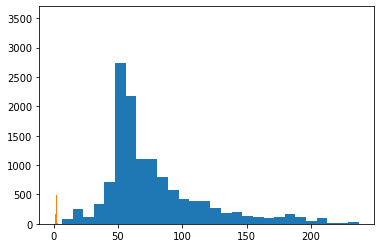

In [18]:
import matplotlib.pyplot as plt
import random
Complete_MPj_no_SuperCon = Complete_MPj[Complete_MPj['is_in_SuperCon'] == 0]
c = plt.hist(SuperCon['MagpieData mean AtomicWeight'].values, bins = 28)
d = plt.hist(SuperCon['MagpieData mean Electronegativity'].values, bins = 28)
samples_atomic = []
samples_electronegativity = []


for i in range(len(c[1])-1):
    samples_to_pick = set(Complete_MPj_no_SuperCon[Complete_MPj_no_SuperCon['MagpieData mean AtomicWeight'].between(c[1][i], c[1][i+1]) == True].index)
    if int(c[0][i]) < len(samples_to_pick):
        samples_atomic.append(random.sample(samples_to_pick, int(c[0][i])))
    else:
        samples_atomic.append(list(samples_to_pick))

for i in range(len(d[1])-1):
    samples_to_pick = set(Complete_MPj_no_SuperCon[Complete_MPj_no_SuperCon['MagpieData mean Electronegativity'].between(d[1][i], d[1][i+1]) == True].index)
    if int(d[0][i]) < len(samples_to_pick):
        samples_electronegativity.append(random.sample(samples_to_pick, int(d[0][i])))
    else:
        samples_electronegativity.append(list(samples_to_pick))
    
samples_random = random.sample(set(Complete_MPj_no_SuperCon.index), len(SuperCon))

    
idxs_iid_atomic = [item for sublist in samples_atomic for item in sublist]
idxs_iid_electronegativity = [item for sublist in samples_electronegativity for item in sublist]
idxs_random = samples_random

Complete_MPj_iid_atomic = pd.concat([SuperCon[['Components', 'is_in_SuperCon']], 
           Complete_MPj_no_SuperCon[['Components', 'is_in_SuperCon']].loc[idxs_iid_atomic]]).reset_index()[['Components', 'is_in_SuperCon']]
Complete_MPj_iid_electronegativity = pd.concat([SuperCon[['Components', 'is_in_SuperCon']], 
           Complete_MPj_no_SuperCon[['Components', 'is_in_SuperCon']].loc[idxs_iid_electronegativity]]).reset_index()[['Components', 'is_in_SuperCon']]
Complete_MPj_random = pd.concat([SuperCon[['Components', 'is_in_SuperCon']], 
           Complete_MPj_no_SuperCon[['Components', 'is_in_SuperCon']].loc[idxs_random]]).reset_index()[['Components', 'is_in_SuperCon']]

In [19]:
df_1 = featurizing(Complete_MPj_iid_atomic)
df_1['is_in_SuperCon'] = Complete_MPj_iid_atomic.set_index('Components')['is_in_SuperCon']

df_2 = featurizing(Complete_MPj_iid_electronegativity)
df_2['is_in_SuperCon'] = Complete_MPj_iid_electronegativity.set_index('Components')['is_in_SuperCon']

df_3 = featurizing(Complete_MPj_random)
df_3['is_in_SuperCon'] = Complete_MPj_random.set_index('Components')['is_in_SuperCon']

df_4 = featurizing(Complete_MPj_random)
df_4['is_in_SuperCon'] = 0
for i in range(len(df_4)):
    df_4['is_in_SuperCon'].iloc[i] = np.round(random.random())

MultipleFeaturizer:   0%|          | 0/25603 [00:00<?, ?it/s]

MultipleFeaturizer:   0%|          | 0/25608 [00:00<?, ?it/s]

MultipleFeaturizer:   0%|          | 0/25608 [00:00<?, ?it/s]

MultipleFeaturizer:   0%|          | 0/25608 [00:00<?, ?it/s]

In [20]:
df_1 = df_1.dropna()
df_2 = df_2.dropna()
df_3 = df_3.dropna()
df_4 = df_4.dropna()

In [21]:
train_df_1, test_df_1 = train_test_split(df_1, test_size = 0.2, random_state = 0)
train_df_2, test_df_2 = train_test_split(df_2, test_size = 0.2, random_state = 0)
train_df_3, test_df_3 = train_test_split(df_3, test_size = 0.2, random_state = 0)
train_df_4, test_df_4 = train_test_split(df_4, test_size = 0.2, random_state = 0)

In [22]:
def create_model(train_df):
    
    '''Pipeline for ETC-vanilla'''
    etc = ExtraTreesClassifier(random_state = 0)
    pipe = Pipeline([
        ('decorrelation', MyDecorrelator(0.9)), 
        ('threshold', VarianceThreshold(threshold = 0)), 
        ('feature_selector', SelectPercentile(f_classif)), 
        ('etc', etc)
    ], verbose = 1)
    param_grid = {
        "etc__n_estimators": [100, 250, 500],    #Tune the number of estimators
        "etc__max_features": [1, 0.75, 0.5],  #Tune the number of features to consider when looking for the best split
        "feature_selector__percentile": [50, 75, 100]       #Tune the percentage of features to retain in terms of f_regression score
    }

    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state = 0)
    search = GridSearchCV(pipe, param_grid, n_jobs=1, verbose = 1, cv = stratified_kfold)
    search.fit(train_df.iloc[:, :-1], train_df.iloc[:, -1])

    return search

In [23]:
model_1 = create_model(train_df_1)
model_2 = create_model(train_df_2)
model_3 = create_model(train_df_3)
model_4 = create_model(train_df_4)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.9s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.8s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.8s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   2.3s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   4.3s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   4.1s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.1s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=  13.8s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=  13.1s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=  14.6s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.1s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=  57.9s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=  58.6s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total= 1.0min
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=  19.8s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=  19.3s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=  19.9s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipel

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed: 38.3min finished


[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.2s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=  26.7s
Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.8s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.8s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.8s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   2.3s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   3.8s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   4.1s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=  11.3s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=  10.9s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=  13.9s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.1s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total= 1.2min
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.1s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total= 1.3min
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.2s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total= 1.2min
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.1s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.1s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=  21.0s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=  19.6s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=  20.3s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipel

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed: 37.4min finished


[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total= 1.0min
Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.1s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.8s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.8s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.1s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.9s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.1s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   2.3s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   3.9s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   4.0s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.1s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=  11.2s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=  12.1s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=  13.7s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=  59.3s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.9s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total= 1.3min
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.2s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total= 1.1min
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=  20.3s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=  20.3s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.1s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=  19.9s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipel

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed: 38.1min finished


[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.2s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=  39.1s
Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   1.3s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   1.3s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   1.3s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   3.8s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   6.6s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   6.5s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=  21.8s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=  21.3s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=  26.4s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total= 2.2min
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total= 1.8min
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total= 1.8min
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=  36.6s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=  38.3s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total=  36.8s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.0s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipel

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed: 65.5min finished


[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   1.5s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.2s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etc, total= 1.1min


In [25]:
test_predictions_1 = model_1.predict(test_df_1.iloc[:, :-1]) 
test_predictions_2 = model_2.predict(test_df_2.iloc[:, :-1]) 
test_predictions_3 = model_3.predict(test_df_3.iloc[:, :-1])
test_predictions_4 = model_4.predict(test_df_4.iloc[:, :-1])

test_labels_1 = test_df_1.iloc[:, -1].values
test_labels_2 = test_df_2.iloc[:, -1].values
test_labels_3 = test_df_3.iloc[:, -1].values
test_labels_4 = test_df_4.iloc[:, -1].values 

test_proba_predictions_1 = model_1.predict_proba(test_df_1.iloc[:, :-1]) 
test_proba_predictions_2 = model_2.predict_proba(test_df_2.iloc[:, :-1]) 
test_proba_predictions_3 = model_3.predict_proba(test_df_3.iloc[:, :-1]) 
test_proba_predictions_4 = model_4.predict_proba(test_df_4.iloc[:, :-1]) 

fpr1, tpr1, thresholds1 = roc_curve(test_labels_1, test_proba_predictions_1.transpose()[1]) 
fpr2, tpr2, thresholds1 = roc_curve(test_labels_2, test_proba_predictions_2.transpose()[1])
fpr3, tpr3, thresholds3 = roc_curve(test_labels_3, test_proba_predictions_3.transpose()[1]) 
fpr4, tpr4, thresholds4 = roc_curve(test_labels_4, test_proba_predictions_4.transpose()[1])

print('F1 =', f1_score(test_labels_1, test_predictions_1), 
     'AUC =', roc_auc_score(test_df_1['is_in_SuperCon'], test_proba_predictions_1.transpose()[1]))
print('F1 =', f1_score(test_labels_2, test_predictions_2), 
     'AUC =', roc_auc_score(test_df_2['is_in_SuperCon'], test_proba_predictions_2.transpose()[1]))
print('F1 =',  f1_score(test_labels_3, test_predictions_3), 
     'AUC =', roc_auc_score(test_df_3['is_in_SuperCon'], test_proba_predictions_3.transpose()[1]))
print('F1 =', f1_score(test_labels_4, test_predictions_4), 
     'AUC =', roc_auc_score(test_df_4['is_in_SuperCon'], test_proba_predictions_4.transpose()[1]))

F1 = 0.942483141610472 AUC = 0.9867485976060113
F1 = 0.945770065075922 AUC = 0.9875786187261146
F1 = 0.9533923303834808 AUC = 0.9896260111716713
F1 = 0.498426435877262 AUC = 0.4930466527691714


In [26]:
model_3.best_params_

{'etc__max_features': 0.75,
 'etc__n_estimators': 250,
 'feature_selector__percentile': 100}

In [27]:
X_train_3 = train_df_3.iloc[:, :-1].loc[:, VarianceThreshold(threshold = 0).fit(train_df_3.iloc[:, :-1]).get_support()]
X_test_3 = test_df_3[X_train_3.columns]

correlated_features = set()  
corr_matrix = X_train_3.iloc[:, :-1].corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9: # we are interested in absolute coeff value
            colname = corr_matrix.columns[i]  # getting the name of column
            correlated_features.add(colname)
            
X_train_3 = X_train_3.drop(labels=correlated_features, axis=1)
X_test_3 = X_test_3[X_train_3.columns]
y_train_3 = train_df_3.iloc[:, -1]
y_test_3 = test_df_3.iloc[:, -1]

In [28]:
etc_3 = ExtraTreesClassifier(random_state=0, n_estimators = 250, max_features = 0.75)
etc_3.fit(X_train_3, y_train_3)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features=0.75,
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=250,
                     n_jobs=None, oob_score=False, random_state=0, verbose=0,
                     warm_start=False)

In [29]:
import shap
explainer = shap.TreeExplainer(etc_3)
shap_values = explainer.shap_values(X_test_3)

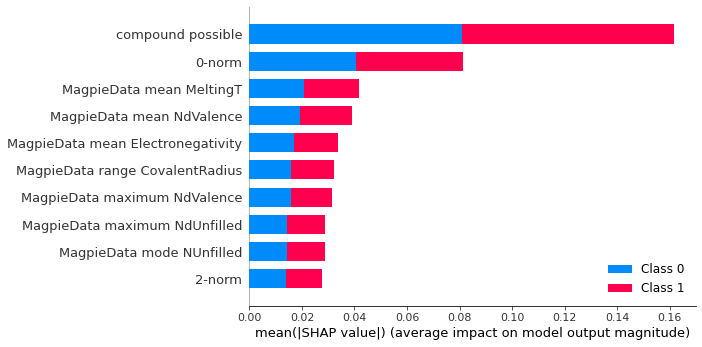

In [30]:
shap.summary_plot(shap_values, X_test_3, max_display = 10)

In [31]:
Output_shap_class1 = pd.DataFrame(shap_values[0], index = X_test_3.index, columns = X_test_3.columns)
Output_shap_class2 = pd.DataFrame(shap_values[1], index = X_test_3.index, columns = X_test_3.columns)

In [32]:
Output_shap_mean_class1 = pd.DataFrame(abs(Output_shap_class1).describe().loc['mean']/sum(abs(Output_shap_class1).describe().loc['mean'])).sort_values('mean', ascending = False)
Output_shap_mean_class2 = pd.DataFrame(abs(Output_shap_class2).describe().loc['mean']/sum(abs(Output_shap_class2).describe().loc['mean'])).sort_values('mean', ascending = False)

In [33]:
import joblib
from joblib import dump, load

In [34]:
joblib.dump(model_3, 'Model_dataset_A_prime.joblib')
joblib.dump(model_4, 'Model_dataset_B_prime.joblib')
joblib.dump(model_1, 'Model_dataset_C_prime.joblib')
joblib.dump(model_2, 'Model_dataset_D_prime.joblib')

['Model_dataset_D_prime.joblib']

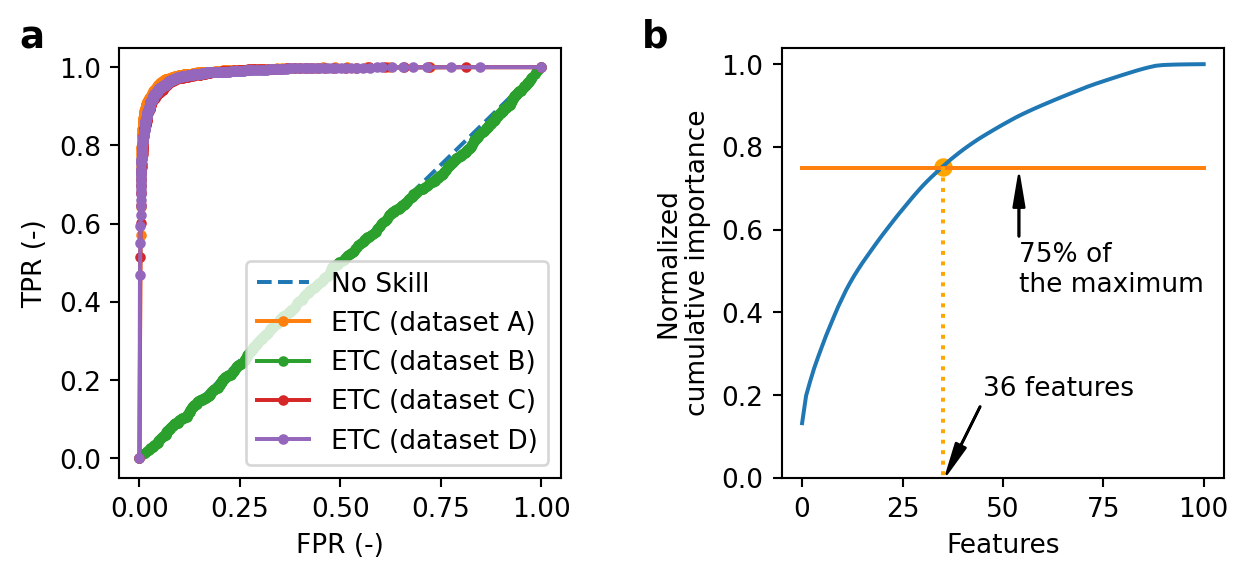

In [38]:
N = np.shape(X_test_3)[1]
k = 0.75
import matplotlib.pyplot as plt
#cumsum = np.cumsum(Output_shap_mean_class1)
normalized_cumulative = np.cumsum(Output_shap_mean_class1)/(np.max(np.cumsum(Output_shap_mean_class1)))

                                                                                       
fig, ax = plt.subplots(1, 2, figsize=(7.5, 3), dpi = 190)
ax[0].plot([0,1], [0,1], linestyle='--', label='No Skill')
ax[0].plot(fpr3, tpr3, marker='.', label='ETC (dataset A)', alpha = 1)
ax[0].plot(fpr4, tpr4, marker='.', label='ETC (dataset B)', alpha = 1)
ax[0].plot(fpr1, tpr1, marker='.', label='ETC (dataset C)', alpha = 1)
ax[0].plot(fpr2, tpr2, marker='.', label='ETC (dataset D)', alpha = 1)


ax[0].set_xlabel('FPR (-)')
ax[0].set_ylabel('TPR (-)')
ax[0].annotate(r'$\mathbf{a}$', xy = (0, 0), xytext = (-.3, 1.05), fontsize = 14)
ax[0].legend()

ax[1].plot(np.arange(N), normalized_cumulative)
ax[1].plot(np.arange(N), k*np.ones(N))
ind_cross1 = np.argmin(np.fabs(normalized_cumulative-k))
#plt.yticks(np.array([0, 0.5, 1]))

ax[1].annotate('%i features' %(ind_cross1+1), xy=(ind_cross1+1, .01), xytext=(ind_cross1+10,.2),
            arrowprops=dict(facecolor='black', shrink=0.000005, width = .1, headwidth=4),
            )
ax[1].annotate('75% of\nthe maximum', xy=(54, 0.73), xytext=(54, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.0005, width = .1, headwidth=4),
            )
ax[1].scatter(ind_cross1, normalized_cumulative.iloc[ind_cross1], color = 'orange')
ax[1].plot((ind_cross1, ind_cross1), (normalized_cumulative.iloc[ind_cross1], 0), color = 'orange', ls = ':')
ax[1].set_ylim(0, 1.04)
ax[1].set_xlabel('Features')
ax[1].set_ylabel('Normalized\ncumulative importance')
ax[1].annotate(r'$\mathbf{b}$', xy = (0, 0), xytext = (-40, 1.04), fontsize = 14)

fig.subplots_adjust(wspace = .5)

#plt.savefig('C:\\Users\\giovanni\\Desktop\\ETC_result.pdf', bbox_inches = 'tight')

#
#plt.show()



plt.show()

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


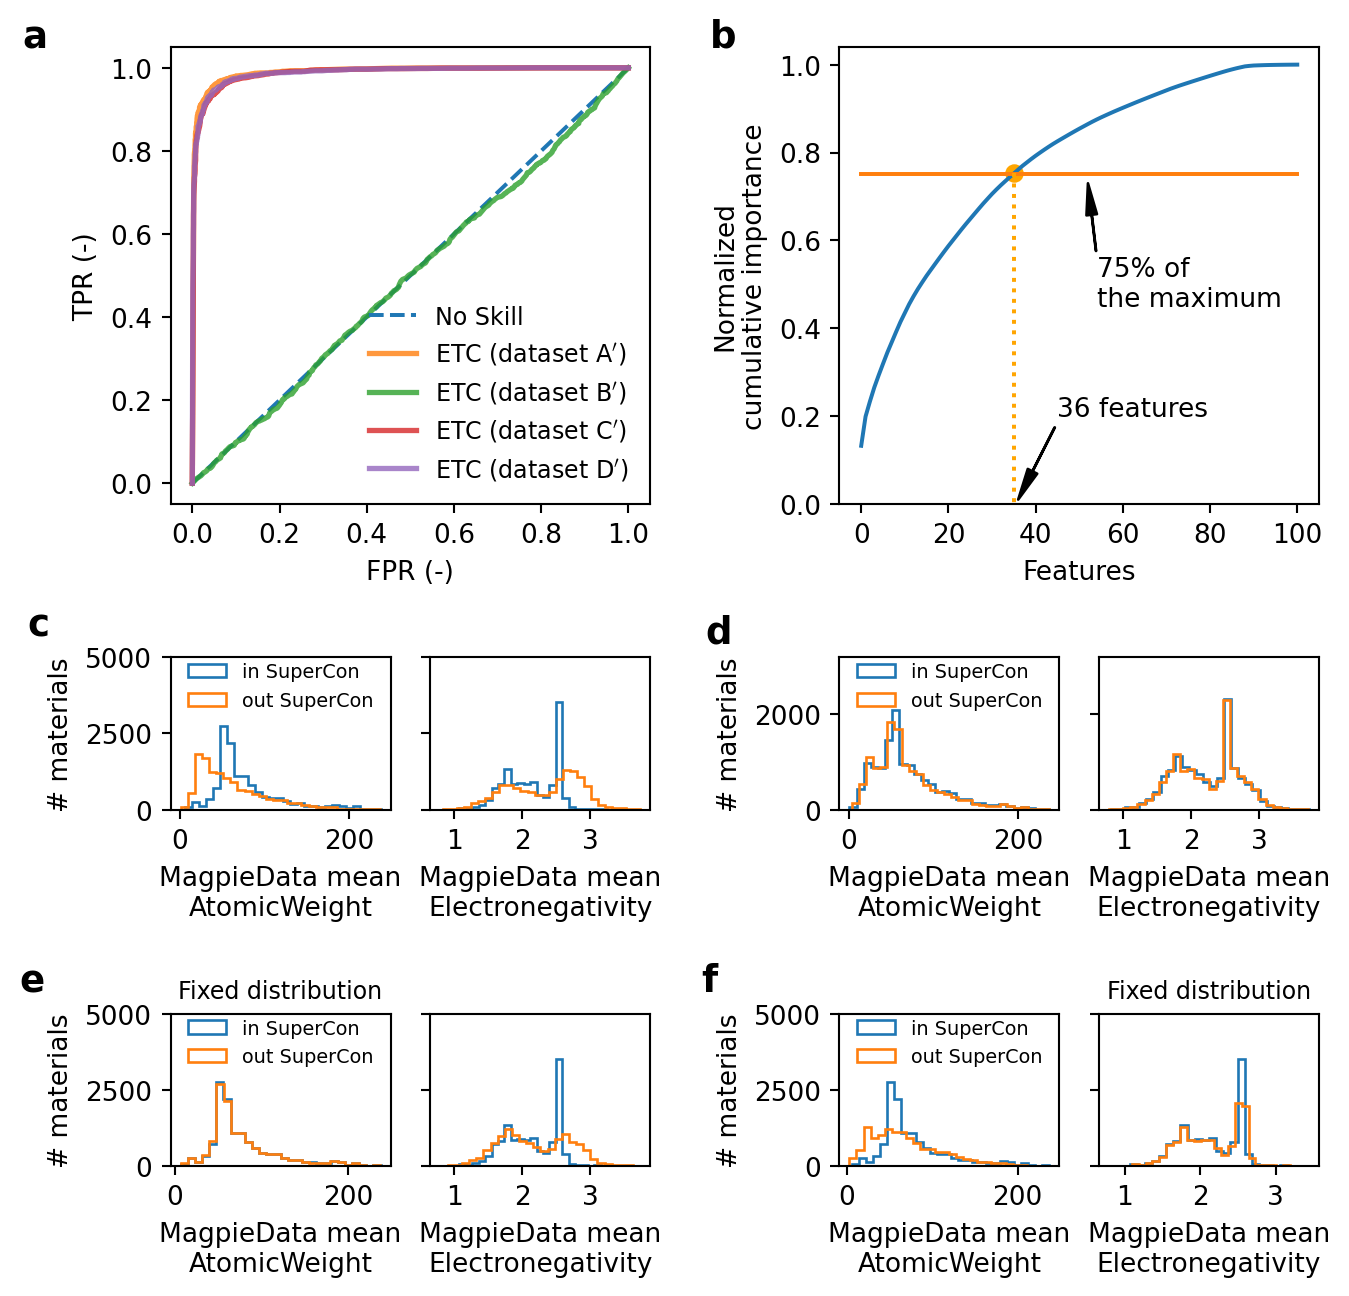

In [47]:
from matplotlib.pyplot import GridSpec
from matplotlib import gridspec
fig = plt.figure(1, figsize=(7.8, 7.8), dpi = 190)

gs = gridspec.GridSpec(5,5, width_ratios=[1,1,0.5,1,1], height_ratios=[.9, 0.15, 0.3, 0.25, 0.3])
#gridspec = dict(1, 5, width_ratios=[1, 1, .03, 1, 1])

ax5 = plt.subplot(gs[0, :2])
ax5.plot([0,1], [0,1], linestyle='--', label='No Skill')
alpha = .8
ax5.plot(fpr3, tpr3, linewidth = 2, label='ETC (dataset A$^{\prime}$)', alpha = alpha)
ax5.plot(fpr4, tpr4, linewidth = 2, label='ETC (dataset B$^{\prime}$)', alpha = alpha)
ax5.plot(fpr1, tpr1, linewidth = 2, label='ETC (dataset C$^{\prime}$)', alpha = alpha)
ax5.plot(fpr2, tpr2, linewidth = 2, label='ETC (dataset D$^{\prime}$)', alpha = alpha)
ax5.set_xlabel('FPR (-)')
ax5.set_ylabel('TPR (-)')
ax5.annotate(r'$\mathbf{a}$', xy = (0, 0), xytext = (-.39, 1.05), fontsize = 14)
ax5.legend(fontsize = 9, frameon = False)

ax6 = plt.subplot(gs[0, 3:5])
ax6.plot(np.arange(N), normalized_cumulative)
ax6.plot(np.arange(N), k*np.ones(N))
ind_cross1 = np.argmin(np.fabs(normalized_cumulative-k))
ax6.annotate('%i features' %(ind_cross1+1), xy=(ind_cross1+1, .01), xytext=(ind_cross1+10,.2),
            arrowprops=dict(facecolor='black', shrink=0.000005, width = .1, headwidth=4),
            )
ax6.annotate('75% of\nthe maximum', xy=(52, 0.73), xytext=(54, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.0005, width = .1, headwidth=4),
            )
ax6.scatter(ind_cross1, normalized_cumulative.iloc[ind_cross1], color = 'orange')
ax6.plot((ind_cross1, ind_cross1), (normalized_cumulative.iloc[ind_cross1], 0), color = 'orange', ls = ':')
ax6.set_ylim(0, 1.04)
ax6.set_xlabel('Features')
ax6.set_ylabel('Normalized\ncumulative importance')
ax6.annotate(r'$\mathbf{b}$', xy = (0, 0), xytext = (-35, 1.04), fontsize = 14)


ax7 = plt.subplot(gs[2, 0])
ax7.hist(df_3[df_3['is_in_SuperCon'] == 1]['MagpieData mean AtomicWeight'], bins = 28, histtype='step', label = 'in SuperCon')
ax7.hist(df_3[df_3['is_in_SuperCon'] == 0]['MagpieData mean AtomicWeight'], bins = 28 , histtype='step', label = 'out SuperCon')
ax7.set_ylim(0, 5000)
ax7.legend(frameon = False, fontsize = 7.3, loc='upper left', bbox_to_anchor=(0, .58, 0.5, 0.5))
ax7.set_ylabel('# materials')
ax7.annotate(r'$\mathbf{c}$', xy = (0, 0), xytext = (-180, 5750), fontsize = 14)
ax7.set_xlabel('MagpieData mean\nAtomicWeight')
ax8 = plt.subplot(gs[2, 1])
ax8.hist(df_3[df_3['is_in_SuperCon'] == 1]['MagpieData mean Electronegativity'], bins = 28 , histtype='step')
ax8.hist(df_3[df_3['is_in_SuperCon'] == 0]['MagpieData mean Electronegativity'], bins = 28 , histtype='step')
ax8.set_ylim(0, 5000)
ax8.tick_params(bottom=True, labelbottom=True, left=True, labelleft=False)
ax8.set_xlabel('MagpieData mean\nElectronegativity')


ax9 = plt.subplot(gs[2, 3])
ax9.hist(df_4[df_4['is_in_SuperCon'] == 1]['MagpieData mean AtomicWeight'], bins = 28, histtype='step', label = 'in SuperCon')
ax9.hist(df_4[df_4['is_in_SuperCon'] == 0]['MagpieData mean AtomicWeight'], bins = 28 , histtype='step', label = 'out SuperCon')
ax9.set_ylim(0, 3200)
ax9.legend(frameon = False, fontsize = 7.3, loc='upper left', bbox_to_anchor=(0, .58, 0.5, 0.5))
#ax3.set_title('Result distribution', fontsize = 9)
ax9.set_ylabel('# materials')
ax9.annotate(r'$\mathbf{d}$', xy = (0, 0), xytext = (-170, 3500), fontsize = 14)
ax9.set_xlabel('MagpieData mean\nAtomicWeight')
ax10 = plt.subplot(gs[2, 4])
ax10.hist(df_4[df_4['is_in_SuperCon'] == 1]['MagpieData mean Electronegativity'], bins = 28 , histtype='step')
ax10.hist(df_4[df_4['is_in_SuperCon'] == 0]['MagpieData mean Electronegativity'], bins = 28 , histtype='step')
ax10.set_ylim(0, 3200)
ax10.tick_params(bottom=True, labelbottom=True, left=True, labelleft=False)
#ax4.set_title('Fixed distribution', fontsize = 9)
ax10.set_xlabel('MagpieData mean\nElectronegativity')

ax1 = plt.subplot(gs[4, 0])
ax1.hist(df_1[df_1['is_in_SuperCon'] == 1]['MagpieData mean AtomicWeight'], bins = 28, histtype='step', label = 'in SuperCon')
ax1.hist(df_1[df_1['is_in_SuperCon'] == 0]['MagpieData mean AtomicWeight'], bins = 28 , histtype='step', label = 'out SuperCon')
ax1.set_ylim(0, 5000)
ax1.legend(frameon = False, fontsize = 7.3, loc='upper left', bbox_to_anchor=(0, .58, 0.5, 0.5))
ax1.set_ylabel('# materials')
ax1.set_title('Fixed distribution', fontsize = 9)
ax1.annotate(r'$\mathbf{e}$', xy = (0, 0), xytext = (-180, 5750), fontsize = 14)
ax1.set_xlabel('MagpieData mean\nAtomicWeight')
ax2 = plt.subplot(gs[4, 1])
ax2.hist(df_1[df_1['is_in_SuperCon'] == 1]['MagpieData mean Electronegativity'], bins = 28 , histtype='step')
ax2.hist(df_1[df_1['is_in_SuperCon'] == 0]['MagpieData mean Electronegativity'], bins = 28 , histtype='step')
ax2.set_ylim(0, 5000)
ax2.tick_params(bottom=True, labelbottom=True, left=True, labelleft=False)
ax2.set_xlabel('MagpieData mean\nElectronegativity')



ax3 = plt.subplot(gs[4, 3])
ax3.hist(df_2[df_2['is_in_SuperCon'] == 1]['MagpieData mean AtomicWeight'], bins = 28, histtype='step', label = 'in SuperCon')
ax3.hist(df_2[df_2['is_in_SuperCon'] == 0]['MagpieData mean AtomicWeight'], bins = 28 , histtype='step', label = 'out SuperCon')
ax3.set_ylim(0, 5000)
ax3.legend(frameon = False, fontsize = 7.3, loc='upper left', bbox_to_anchor=(0, .58, 0.5, 0.5))
#ax3.set_title('Result distribution', fontsize = 9)
ax3.set_ylabel('# materials')
ax3.annotate(r'$\mathbf{f}$', xy = (0, 0), xytext = (-170, 5750), fontsize = 14)
ax3.set_xlabel('MagpieData mean\nAtomicWeight')
ax4 = plt.subplot(gs[4, 4])
ax4.hist(df_2[df_2['is_in_SuperCon'] == 1]['MagpieData mean Electronegativity'], bins = 28 , histtype='step')
ax4.hist(df_2[df_2['is_in_SuperCon'] == 0]['MagpieData mean Electronegativity'], bins = 28 , histtype='step')
ax4.set_ylim(0, 5000)
ax4.tick_params(bottom=True, labelbottom=True, left=True, labelleft=False)
ax4.set_title('Fixed distribution', fontsize = 9)
ax4.set_xlabel('MagpieData mean\nElectronegativity')

plt.savefig('C:\\Users\\giovanni\\Desktop\\ETC_superconductors_complete.pdf', bbox_inches = 'tight')

plt.show()
